# Anomaly Detection


> Not every outlier is a wrong value!

WHAT IS OUTLIER？

> In statistics, an outlier is an observation point that is distant from other observations.



The most common reasons for causing outliers are:

1.Data entry errors (human errors)
2.Measurement errors (instrument errors)
3.Experimental errors (errors in data extraction or experimental planning/execution)
4.Deliberate (false outliers used for testing outlier detection methods)
5.Data processing errors (unexpected data processing or dataset mutation)
6.Sampling errors (extracting or mixing data from incorrect or various sources)
7.Naturally occurring (not errors, but rather data novelty due to data diversity)



Anomaly detection (or outlier detection) is the identification of rare items, events or observations which raise suspicions by differing significantly from the majority of the data.

Methods for outlier detection:

1.Model-based techniques: First, establish a data model, and outliers are objects that do not fit the model perfectly. If the model is a collection of clusters, outliers are objects that do not significantly belong to any cluster. In the case of using a regression model, outliers are objects that are relatively far from the predicted values.

2.Neighbor-based techniques: Typically, proximity measures can be defined between objects, and outlier objects are those that are far from other objects.

3.Density-based techniques: An object is classified as an outlier only when its local density is significantly lower than that of most of its neighbors."

In [ ]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

%matplotlib inline

In [ ]:
# 读取数据

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
# 全集
fullset = pd.concat([train,test],ignore_index=True)

## Methods for Detecting Outliers


**Univariate**

- [Boxplot](#Boxplot)
- [Zscore](#Zscore)
- [IQR](#IQR)
- [Hampel](#Hampel)

**Multivariate**

- [DBSCAN](#DBSCAN)
- [OneClassSVM](#OneClassSVM)
- [EllipticEnvelope](#EllipticEnvelope)
- [IsolationForest](#IsolationForest)
- [LocalOutlierFactor](#LocalOutlierFactor)

### Boxplot

![](https://miro.medium.com/max/1400/1*0MPDTLn8KoLApoFvI0P2vQ.png)

In [ ]:
sample = fullset.sample(random_state=0,frac = .1)
sample = sample.replace(-1,np.nan)

In [ ]:
from data_management import meta

In [ ]:
metadata = meta(train,test)

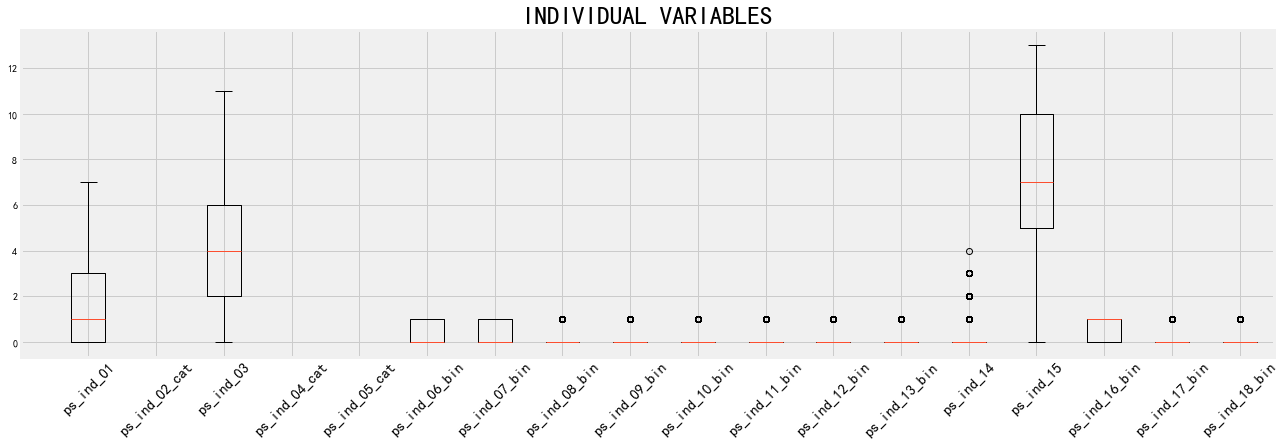

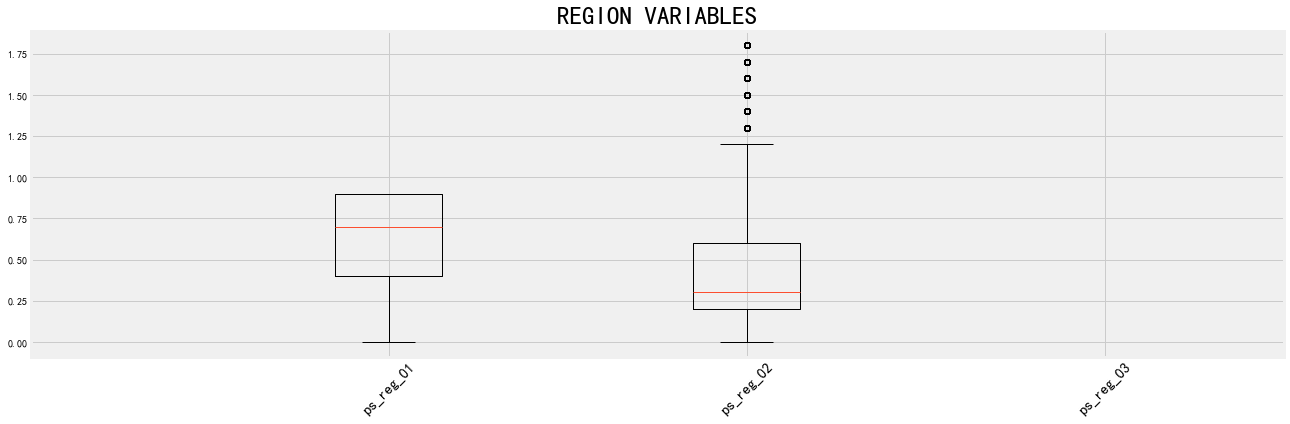

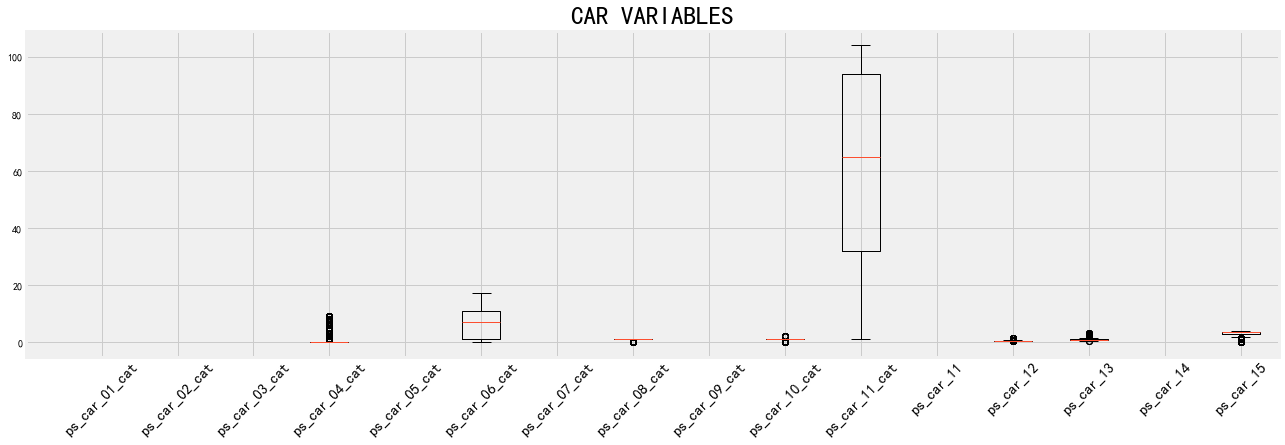

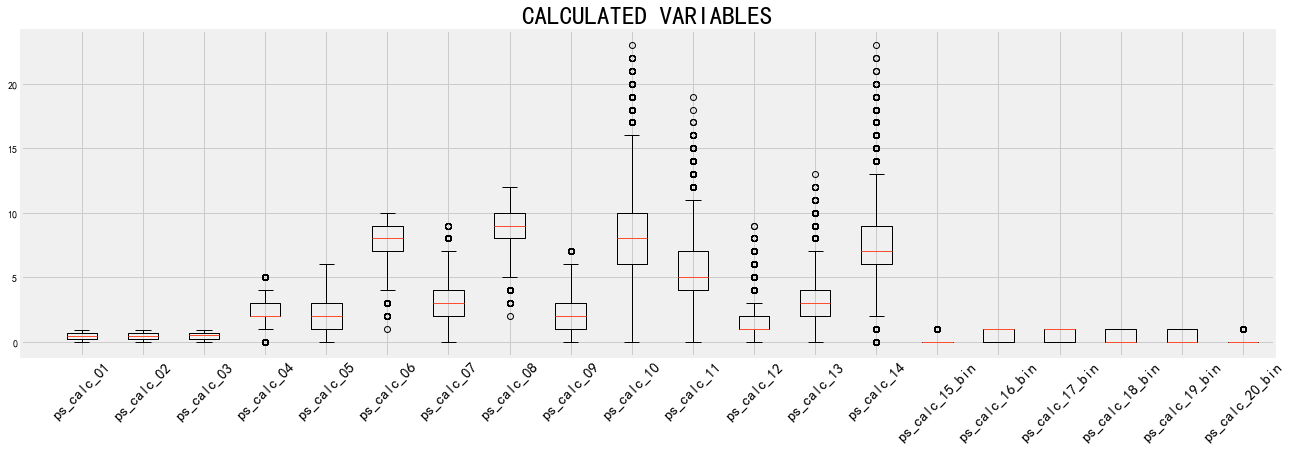

In [ ]:
plt.figure(figsize = (20,6))
ind_idx = metadata[metadata['category'] == 'individual'].index
ticks = list(ind_idx)
ticks = [''] + ticks
box1 = plt.boxplot(sample[ind_idx])
rang = range(0, len(ticks))
plt.title("individual variables".upper(),fontsize = 25)
plt.xticks(rang, ticks, rotation=45, fontsize = 15)
pass

plt.figure(figsize = (20,6))
ind_idx = metadata[metadata['category'] == 'region'].index
ticks = list(ind_idx)
ticks = [''] + ticks
box2 = plt.boxplot(sample[ind_idx])
rang = range(0, len(ticks))
plt.title("region variables".upper(),fontsize = 25)
plt.xticks(rang, ticks, rotation=45, fontsize = 15)
pass

plt.figure(figsize = (20,6))
ind_idx = metadata[metadata['category'] == 'car'].index
ticks = list(ind_idx)
ticks = [''] + ticks
box3 = plt.boxplot(sample[ind_idx])
rang = range(0, len(ticks))
plt.title("car variables".upper(),fontsize = 25)
plt.xticks(rang, ticks, rotation=45, fontsize = 15)
pass

plt.figure(figsize = (20,6))
ind_idx = metadata[metadata['category'] == 'calculated'].index
ticks = list(ind_idx)
ticks = [''] + ticks
box4 = plt.boxplot(sample[ind_idx])
rang = range(0, len(ticks))
plt.title("calculated variables".upper(),fontsize = 25)
plt.xticks(rang, ticks, rotation=45, fontsize = 15)
pass

In [ ]:
# from matplotlib.cbook import boxplot_stats  
# boxplot_data = sample[metadata.index]
# for idx,i in enumerate(boxplot_stats(boxplot_data)):
#     outliers = i['fliers'] if len(i['fliers']) > 0 else 'No Outliers'
#     print(f"{boxplot_data.columns[idx]}==>{outliers}")

### Zscore

> The Z-score（标准分数） is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.


> Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution.

$$
z = \frac{(x-\mu)}{\sigma}
$$

那么，如何利用z-score来检测异常值呢？当计算z-score时，我们实际在数据中心化，并且寻找距离零点比较远的数据点，这就说明是离群的，一般来说z-score大于3或者小于-3，就说明此数据点是离群的。

In [ ]:
from scipy import stats
z_score = np.abs(stats.zscore(fullset))

In [ ]:
threshold = 3
np.where(z_score > 3)

(array([      2,       5,      10, ..., 1488023, 1488023, 1488023],
       dtype=int64),
 array([ 3, 21, 26, ..., 26, 35, 36], dtype=int64))

In [ ]:
np.where(z_score > 3)[0].shape

(524548,)

In [ ]:
# for r,c,in zip(np.where(z_score > 3)[0],np.where(z_score > 3)[1]):
#     print(fullset.iloc[r,c])

The z-score method is not robust, as you can see, over 500,000 data points have been defined as outliers, which is quite extreme. It is also not very easy to pinpoint the missing values that need to be addressed using this method. Z-score is generally used for datasets with a small data size, low dimensionality, and many continuous variables.

### IQR

> The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In [ ]:
iqr_df = fullset.drop(['id','target'],axis=1)
Q1 = iqr_df.quantile(0.25)
Q3 = iqr_df.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
cond = (iqr_df < (Q1 - 1.5 * IQR)) |(iqr_df > (Q3 + 1.5 * IQR))

In [ ]:
iqr_df[~cond].replace(np.nan,'异常值')

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2.0,5,1,0.0,0,1,0.0,0.0,0.0,...,9.0,1.0,5.0,8.0,0.0,1,1,0,0,异常值
1,1,1.0,7,0,0.0,0,0,异常值,0.0,0.0,...,3.0,1.0,1.0,9.0,0.0,1,1,0,1,0.0
2,5,异常值,9,1,0.0,0,0,异常值,0.0,0.0,...,4.0,2.0,7.0,7.0,0.0,1,1,0,1,0.0
3,0,1.0,2,0,0.0,1,0,0.0,0.0,0.0,...,2.0,2.0,4.0,9.0,0.0,0,0,0,0,0.0
4,0,2.0,0,1,0.0,1,0,0.0,0.0,0.0,...,3.0,1.0,1.0,3.0,0.0,0,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488023,0,1.0,6,0,0.0,0,1,0.0,0.0,0.0,...,4.0,2.0,3.0,4.0,0.0,1,0,0,1,0.0
1488024,5,3.0,5,1,0.0,0,0,异常值,0.0,0.0,...,6.0,2.0,2.0,11.0,0.0,0,1,1,0,0.0
1488025,0,1.0,5,0,0.0,1,0,0.0,0.0,0.0,...,5.0,2.0,2.0,11.0,0.0,1,1,0,0,0.0
1488026,6,1.0,5,1,0.0,0,0,0.0,异常值,0.0,...,1.0,1.0,2.0,7.0,异常值,1,0,0,0,0.0


It's worth mentioning that the values selected by the IQR method are the same as those filtered out by the box plot！

```diff
+ Pros:Simple and straightforward, high interpretability.
- Cons:Poor robustness, low accuracy, can only remove obvious outliers
```

### Hampel

The Hampel Filter is a robust method for detecting and handling outliers in time series data. It relies on the Median Absolute Deviation (MAD) and employs a rolling window for the identification of outliers. MAD is a robust measure of data dispersion, calculated as the median of the absolute deviations from the median value.

In [ ]:
def random_walk_with_outliers(origin, n_steps, perc_outliers=0.0, outlier_mult=10, seed=42):

    assert (perc_outliers >= 0.0) & (perc_outliers <= 1.0)
    
    #set seed for reproducibility
    np.random.seed(seed)
    
    # possible steps
    steps = [-1, 1]

    # simulate steps
    steps = np.random.choice(a=steps, size=n_steps-1)
    rw = np.append(origin, steps).cumsum(0)
    
    # add outliers
    n_outliers = int(np.round(perc_outliers * n_steps, 0))
    indices = np.random.randint(0, len(rw), n_outliers)
    rw[indices] = rw[indices] + steps[indices + 1] * outlier_mult
    
    return rw, indices

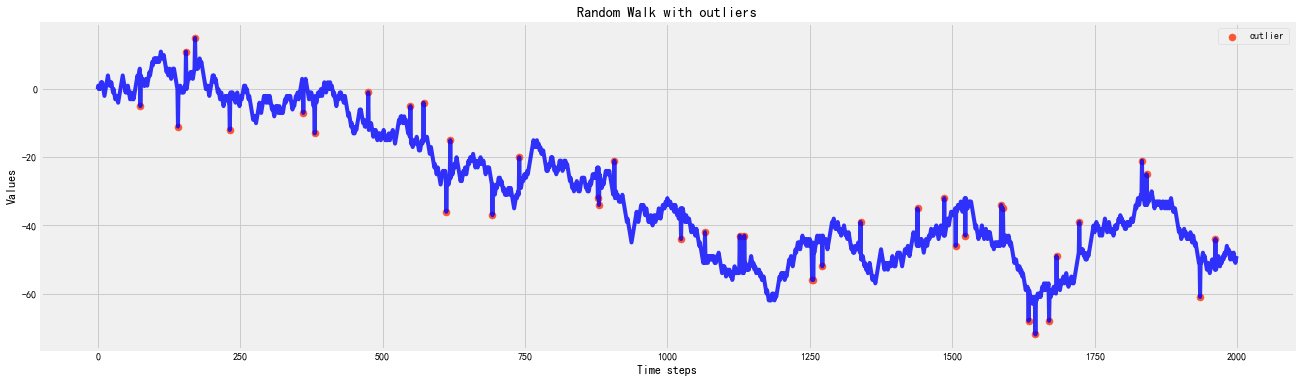

In [ ]:
plt.figure(figsize = [20,6])
rw, outlier_ind = random_walk_with_outliers(0, 2000, 0.02,seed = 2022)
plt.plot(np.arange(len(rw)), rw, c = 'b',alpha = .8)
plt.scatter(outlier_ind, rw[outlier_ind], c='#fc5531', label='outlier',s = 50)
plt.title('Random Walk with outliers')
plt.xlabel('Time steps')
plt.ylabel('Values')
plt.legend();

In [ ]:
def evaluation(series, true_indices, detected_indices):
    # calculate metrics
    tp = list(set(detected_indices).intersection(set(true_indices)))
    fp = list(set(detected_indices).difference(set(true_indices)))
    fn = list(set(true_indices).difference(set(detected_indices)))
    perc_detected = 100 * len(tp) / len(true_indices)
    
    # create the plot
    fix, ax = plt.subplots(2, 1, figsize=(25, 6*3))
    
    ax[0].plot(np.arange(len(series)), series,c = '#24292e',alpha = .8, linewidth = .5);
    ax[0].scatter(true_indices, series[true_indices], c='g', label='true outlier',s = 100)
    ax[0].set_title('实际离群值',fontsize = 35)
    ax[0].legend(fontsize = 20)
    
    ax[1].plot(np.arange(len(series)), series, c = '#3a9cfb',alpha = .8, linewidth = .5);
    ax[1].scatter(tp, series[tp], c='g', label='true positive',s = 100)
    ax[1].scatter(fp, series[fp], c='r', marker = 'x', label='false positive', s = 100)
    ax[1].scatter(fn, series[fn], c='k', marker = 'x', label='false negative', s = 100)
    ax[1].set_title('处理后结果对比',fontsize = 35)
    ax[1].legend(fontsize = 20)
    
    
    # print out summary
    print('-' * 25 + ' Summary ' + '-' * 25)
    print(f'序列中离群值数量: {len(true_indices)}')
    print(f'所检测出来的数量: {len(detected_indices)}')
    print(f'检测正确的数量: {len(tp)} ({perc_detected:.2f}% of all outliers).')
    print('-' * 59)
    
    return tp, fp, fn

In [ ]:
def hampel_filter(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    
    k = 1.4826 # 定义K，应对高斯分布

    indices = []

    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):  # 移动窗口
        # 计算窗口内数据的MAD
        window_median = np.median(input_series[(i - window_size):(i + window_size)])
        k_MAD = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - window_median))
        if (np.abs(input_series[i] - window_median) > n_sigmas * k_MAD):
            new_series[i] = window_median
            indices.append(i)    
    return new_series, indices

In [ ]:
def iqr_filter(input_series, window_size):
    
    n = len(input_series)
    new_series = input_series.copy()
    indices = []
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):  # 移动窗口
        # 计算窗口内数据的MAD
        s = input_series[(i - window_size):(i + window_size)]
        s = pd.Series(s)
        Q1 = s.quantile(0.25)
        Q3 = s.quantile(0.75)
        IQR = Q3 - Q1
        cond = (input_series[i] < (Q1 - 1.5 * IQR)) |(input_series[i] > (Q3 + 1.5 * IQR))
        if cond:
            new_series[i] = input_series[i]
            indices.append(i)  
    return new_series, indices

In [ ]:
res_iqr, detected_outliers_iqr = iqr_filter(rw, 10)
res_hampel, detected_outliers_hampel = hampel_filter(rw, 10)

Hampel处理后 vs. IQR处理后

------------------------- Summary -------------------------
序列中离群值数量: 40
所检测出来的数量: 45
检测正确的数量: 38 (95.00% of all outliers).
-----------------------------------------------------------


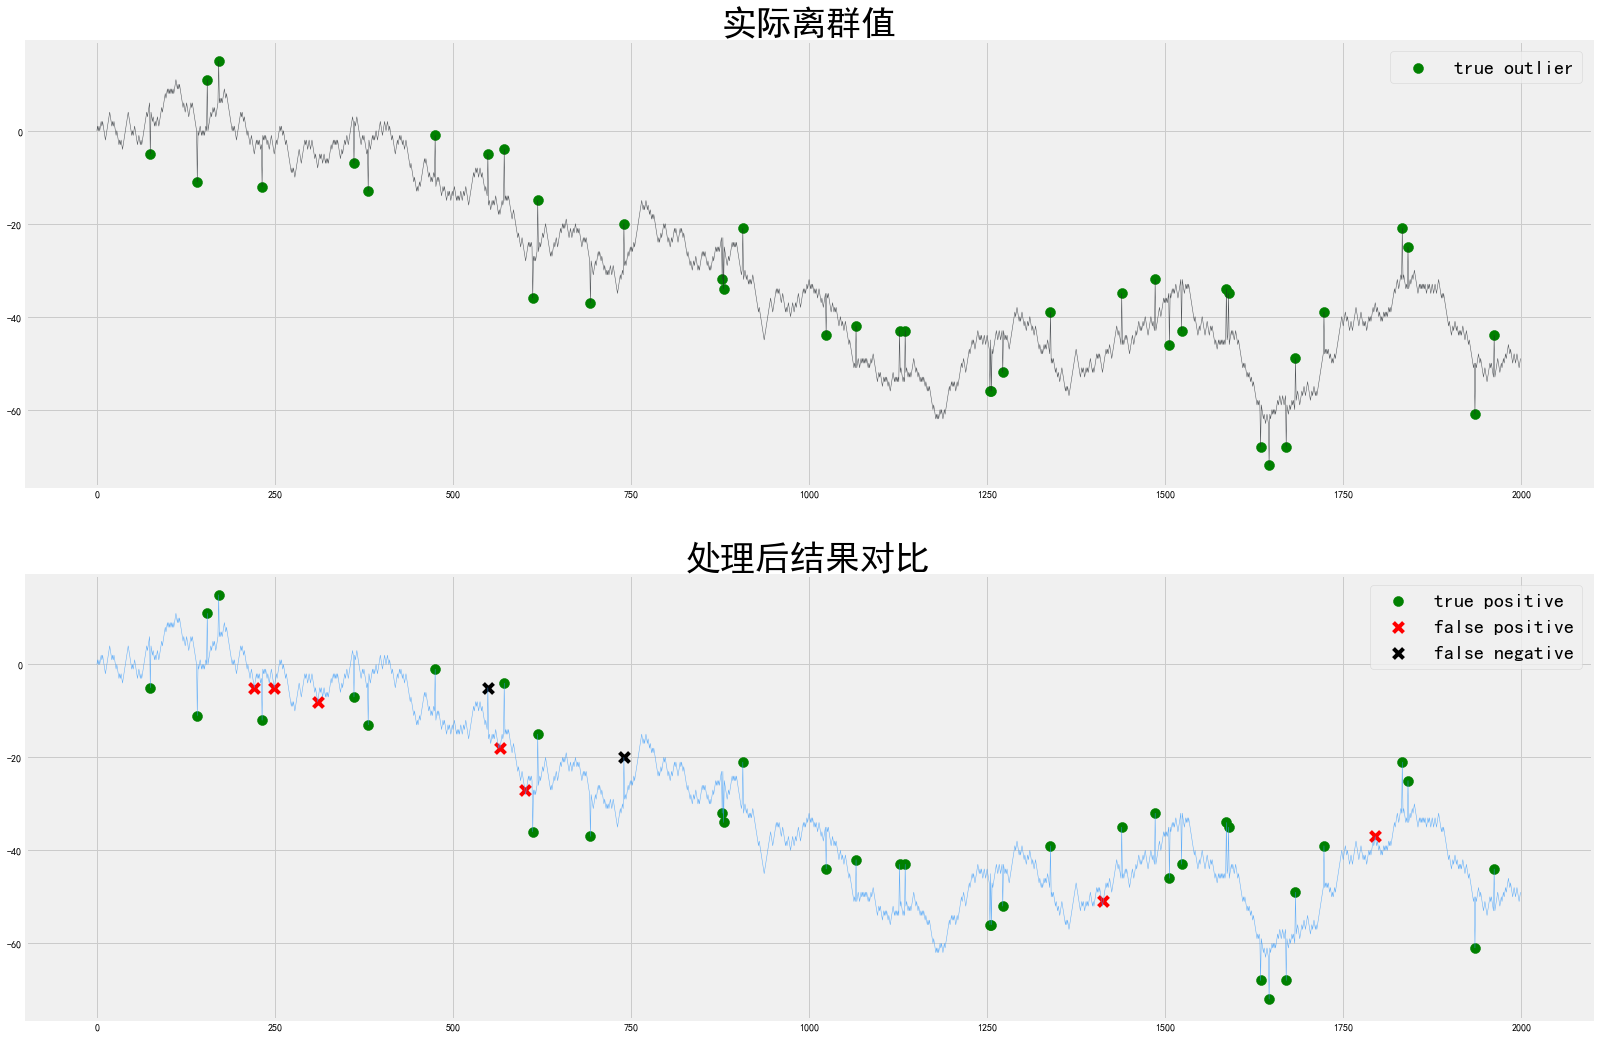

In [ ]:
# Hampel
tp, fp, fn = evaluation(rw, outlier_ind, detected_outliers_hampel)

------------------------- Summary -------------------------
序列中离群值数量: 40
所检测出来的数量: 44
检测正确的数量: 37 (92.50% of all outliers).
-----------------------------------------------------------


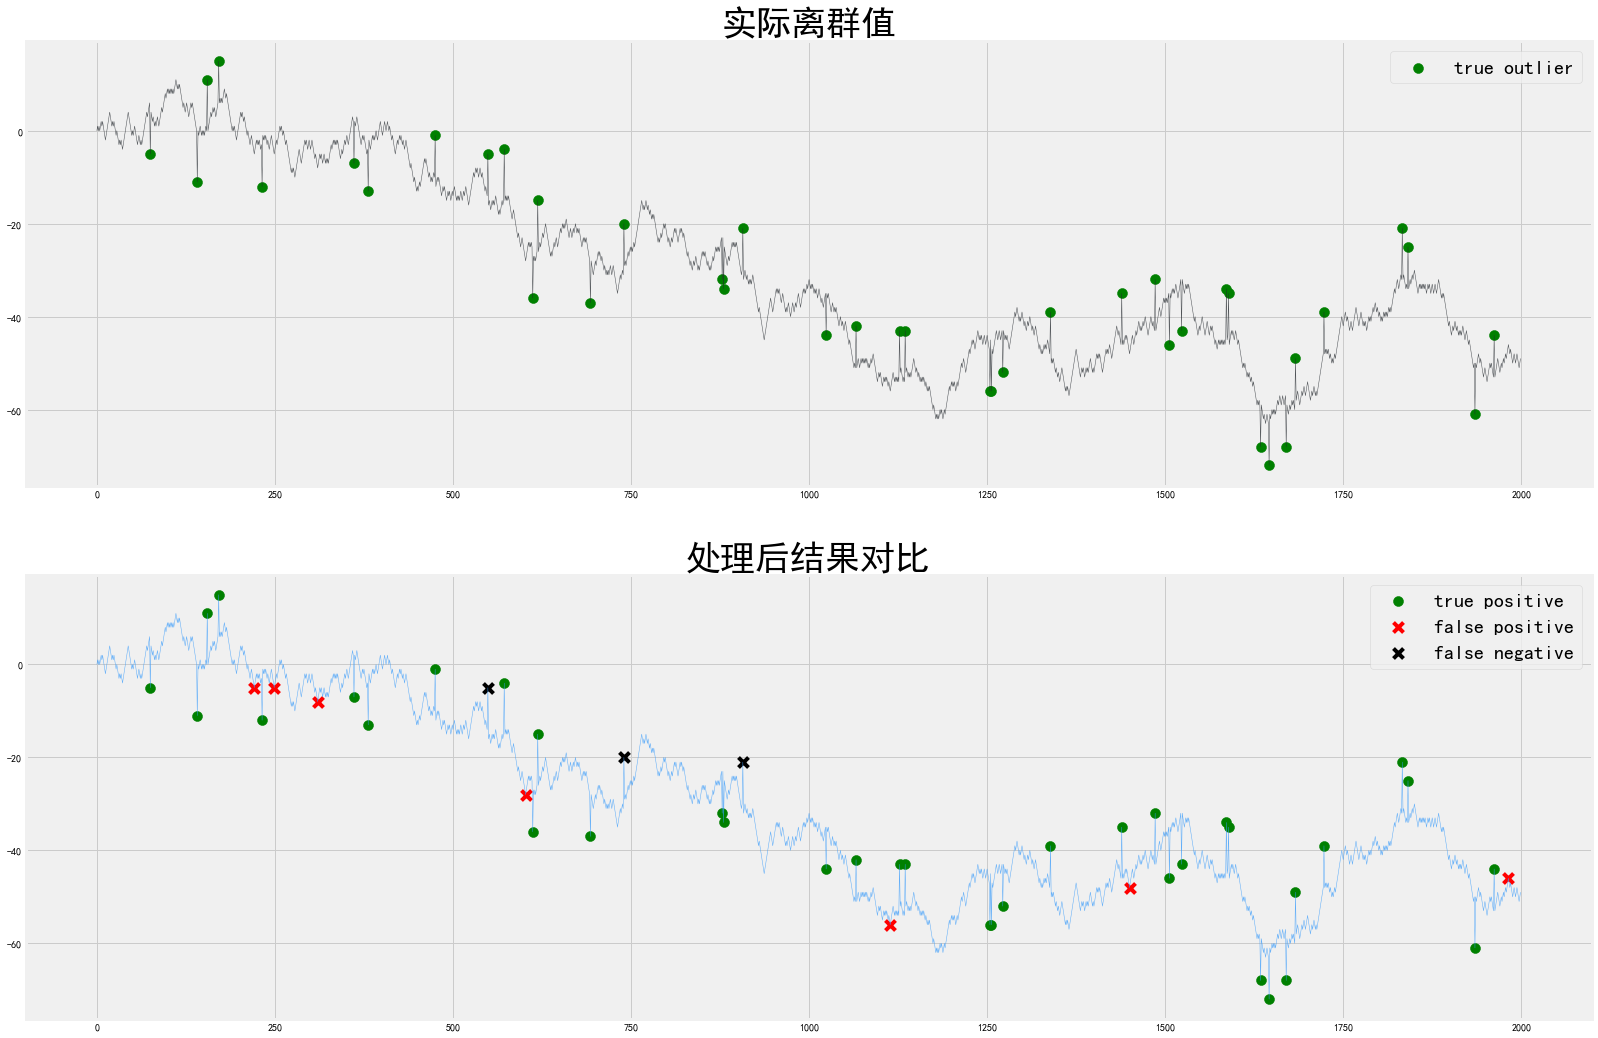

In [ ]:
# IQR
tp, fp, fn = evaluation(rw, outlier_ind, detected_outliers_iqr)


<div align=center>
<img src=https://github.com/datoujinggzj/WhaleDataScienceProject/blob/master/pic/sep.gif?raw=true width='900' />
</div>



> Outliers are not labeled! (otherwise it’s just imbalanced classification)


### DBSCAN

Density-Based Clustering refers to unsupervised learning methods that identify distinctive groups/clusters in the data, based on the idea that a cluster in data space is a contiguous region of high point density, separated from other such clusters by contiguous regions of low point density.

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
def plot_2d_space(X, y, label='Classes'):  
    
    colors = ['#20beff', '#d80012']
    markers = ['o', '*']
    plt.figure(figsize = [20,8])
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m,
            s = 80
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

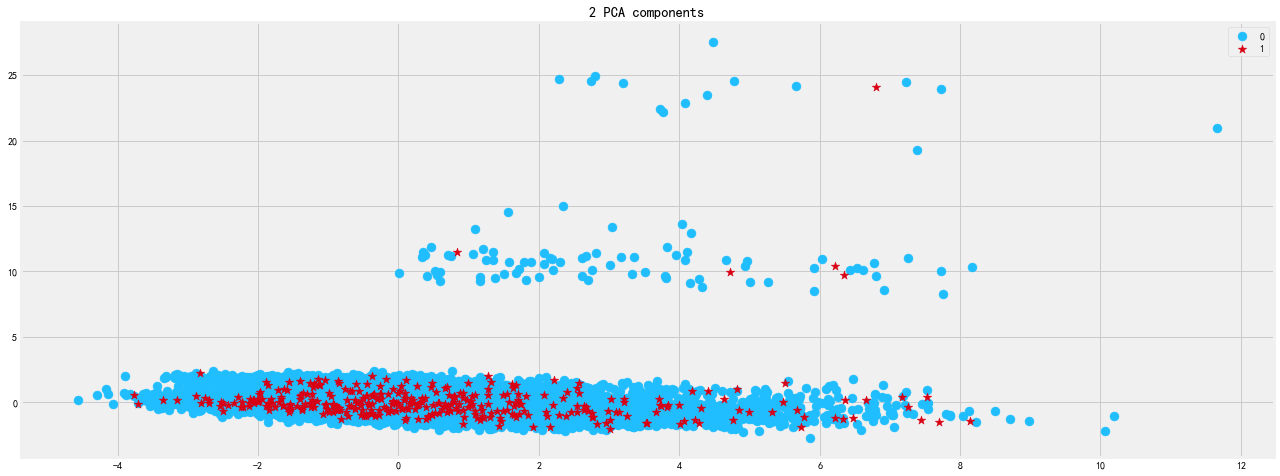

In [ ]:
df = train.sample(10000)
X = df.drop(['id','target'],axis=1)
y = df.target

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_2d_space(X_pca, y, '2 PCA components')

In [ ]:
dbscan=DBSCAN()
dbscan.fit(X_pca)
pass

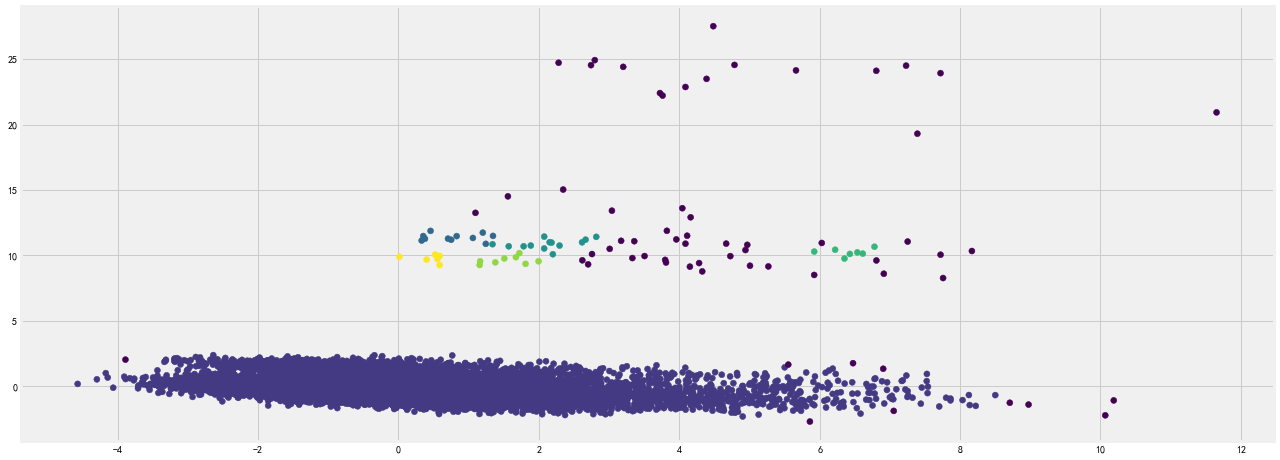

In [ ]:
# visualize outputs
colors = dbscan.labels_
plt.figure(figsize = [20,8])
plt.scatter(X_pca[:,0], X_pca[:,1], c = colors)

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

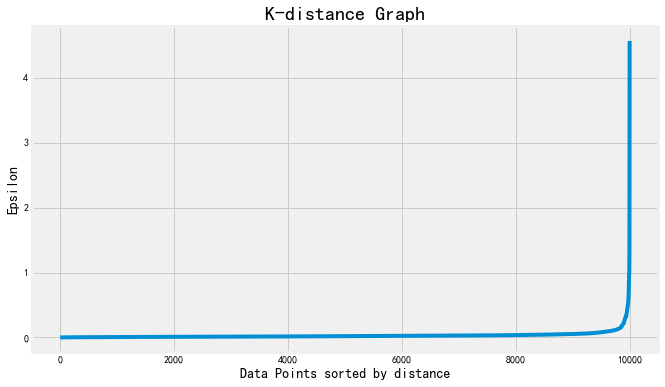

In [ ]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

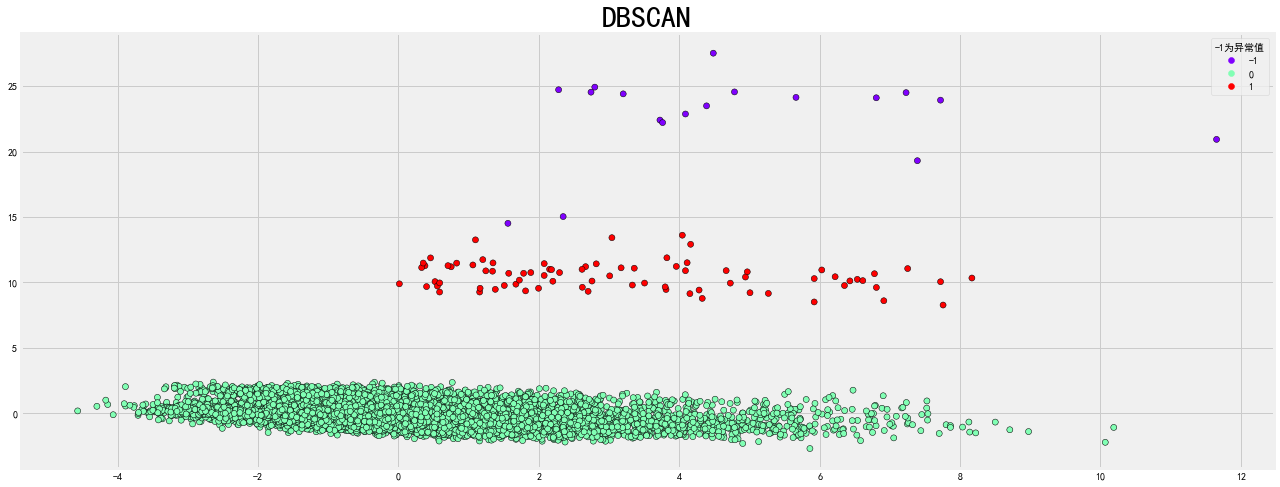

In [ ]:
# 根据上图，eps = 2
model = DBSCAN(eps = 2, min_samples = 10).fit(X_pca)

colors = model.labels_
colormap = list(pd.Series(colors).unique())
plt.figure(figsize = [20,8])
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c = colors, cmap = 'rainbow',edgecolors='black')
plt.title('DBSCAN', fontsize = 30)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sorted(colormap),
           title="-1为异常值")

### EllipticEnvelope

Elliptical Envelope creates an imaginary elliptical area around a given dataset. Values that fall inside the envelope are considered normal data and anything outside the envelope is returned as outliers.

This is a robust outlier detection method based on variance. The algorithm assumes that normal samples follow a Gaussian distribution and learns a two-dimensional elliptical distribution. It makes a robust covariance estimation based on the data, obtaining a set of mean and variance values suitable for describing the current dataset. It then learns an ellipse that surrounds central sample points while ignoring outliers, aiming to differentiate between normal points and outliers.

In [ ]:
from sklearn.covariance import EllipticEnvelope

In [ ]:
ee = EllipticEnvelope(contamination=0.1).fit(X_pca)
pred = ee.predict(X_pca)

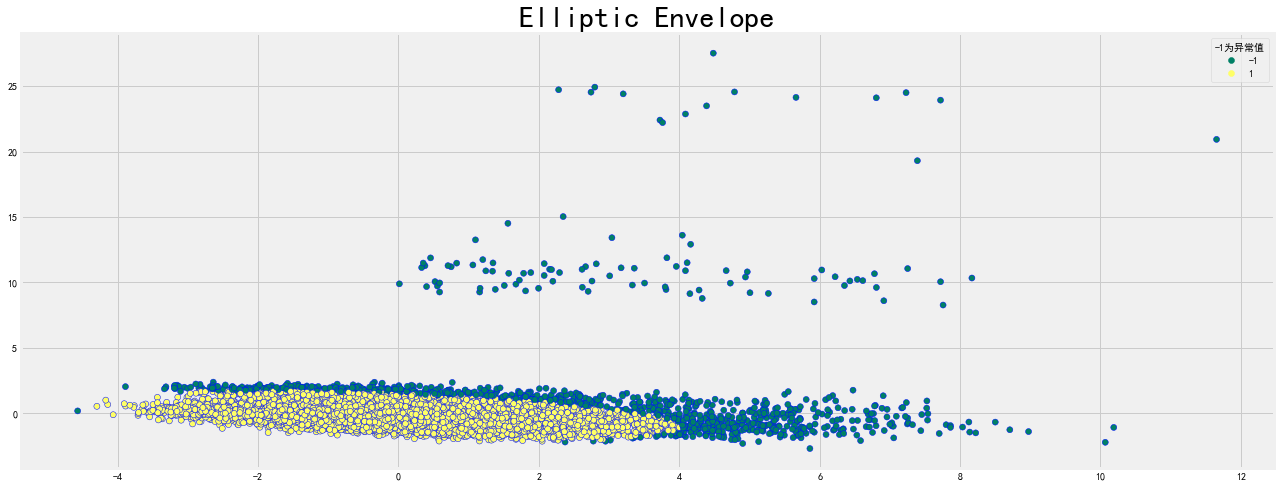

In [ ]:
colors = pred
colormap = list(pd.Series(colors).unique())
plt.figure(figsize = [20,8])
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c = colors, cmap = 'summer',edgecolors='#000fff')
plt.title('Elliptic Envelope', fontsize = 30)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sorted(colormap),
           title="-1为异常值")

In [ ]:
# D'Agostino and Pearson's Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
seed(1)
stat, p = normaltest(X_pca[:,0])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=1679.170, p=0.000
Sample does not look Gaussian (reject H0)


In [ ]:
# D'Agostino and Pearson's Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
seed(1)
stat, p = normaltest(X_pca[:,1])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=13809.793, p=0.000
Sample does not look Gaussian (reject H0)


In [ ]:
x1 = 2*np.random.randn(10000)
x2 = np.random.randn(10000)+100

In [ ]:
gaussian_demo = np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)),axis=1)
ee = EllipticEnvelope(contamination=0.05).fit(gaussian_demo)
pred = ee.predict(gaussian_demo)

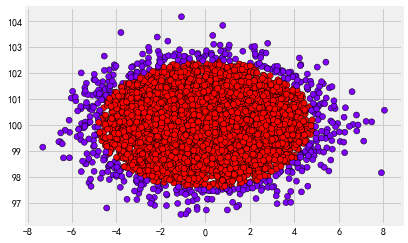

In [ ]:
colors = pred
plt.scatter(x1, x2, c = colors, cmap = 'rainbow',edgecolors='black')

### OneClassSVM

One-Class Support Vector Machine (One-Class SVM) is a machine learning algorithm used for outlier detection and novelty detection. It belongs to the family of Support Vector Machines, but unlike traditional SVMs, it is typically used for problems where you have a significant imbalance between the normal (inlier) class and the anomalous (outlier) class, and the focus is on detecting the anomalies.

- Also uses Gaussian kernel to cover data

- Only select support vectors (not all points)

- Specify outlier ratio (contamination) via nu

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)
oneclass = OneClassSVM(nu=.05).fit(X_pca_scaled)
pred = oneclass.predict(X_pca_scaled)

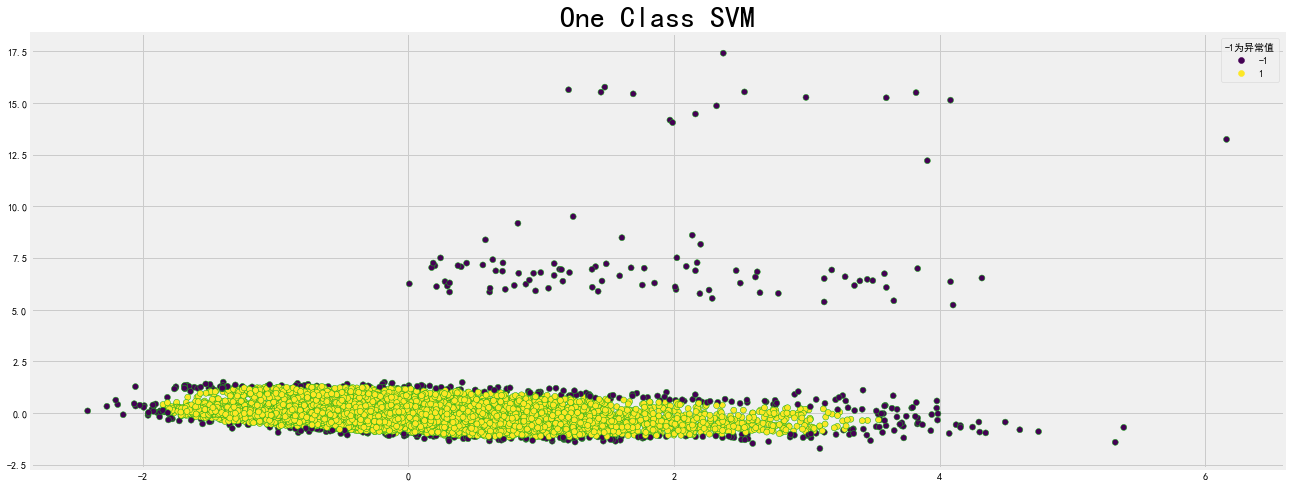

In [ ]:
colors = pred
colormap = list(pd.Series(colors).unique())
plt.figure(figsize = [20,8])
scatter = plt.scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c = colors,edgecolors="#1aad19")
plt.title('One Class SVM', fontsize = 30)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sorted(colormap),
           title="-1为异常值")

### IsolationForests¶

Isolation Forests is an anomaly detection algorithm in machine learning. It is a tree-based ensemble method designed for the purpose of identifying anomalies or outliers in a dataset. Isolation Forests are known for their efficiency in detecting anomalies, even in high-dimensional datasets, and they work well when you have a mix of both point anomalies and contextual anomalies.

- non-parametric estimate 
- no probability model
- no parameters to tune



![](https://csdl-images.ieeecomputer.org/trans/tk/2021/04/figures/harir8-2947676.gif)

the idea behind Isolation Forests is that if you build a random tree on a dataset, then if you want to figure out how easy it is to split a particular point, it's much easier to split an outlier than a point that is densely surrounded by data.

The idea here is that you build many completely random trees, and it's entirely unsupervised, so it's just kind of chopping through the data in some way. We see how deep we need to go to isolate one data point from the other data points.

If, on average, we have to go deep into the tree, it may be because some of our data is dense, and it's not an outlier. So, on average, if we separate this point early, it might be an outlier.

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.05),max_features=1.0)
model.fit(X_pca_scaled)

scores =model.decision_function(X_pca_scaled)
pred =model.predict(X_pca_scaled)

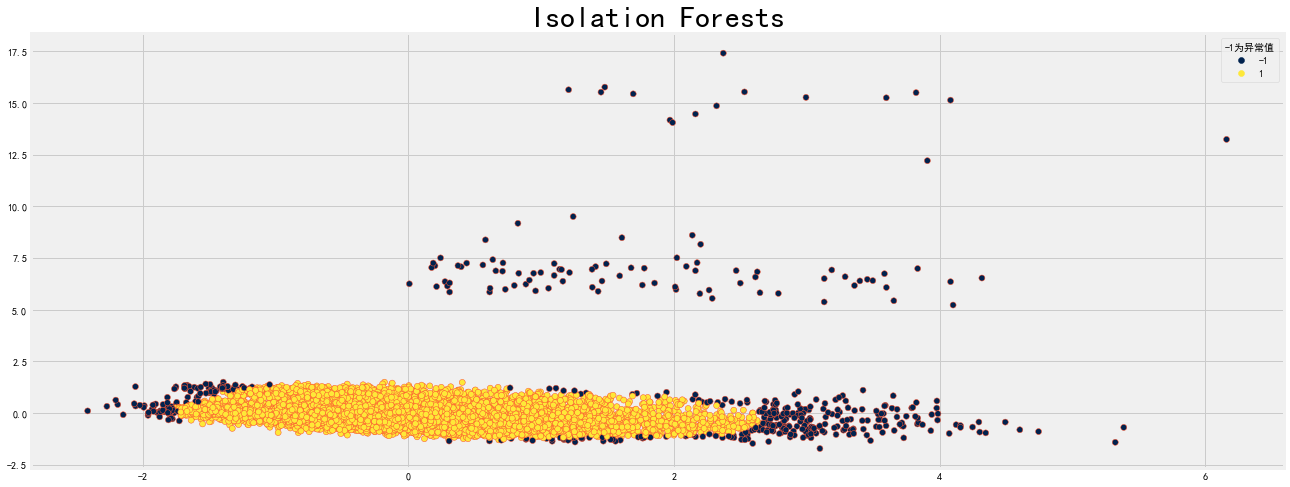

In [ ]:
colors = pred
colormap = list(pd.Series(colors).unique())
plt.figure(figsize = [20,8])
scatter = plt.scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c = colors, cmap = 'cividis',edgecolors='#fc5531')
plt.title('Isolation Forests', fontsize = 30)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sorted(colormap),
           title="-1为异常值")

### LocalOutlierFactor

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
model = LocalOutlierFactor(n_neighbors=35, contamination=.1)
pred = model.fit_predict(X_pca_scaled)
scores = model.negative_outlier_factor_

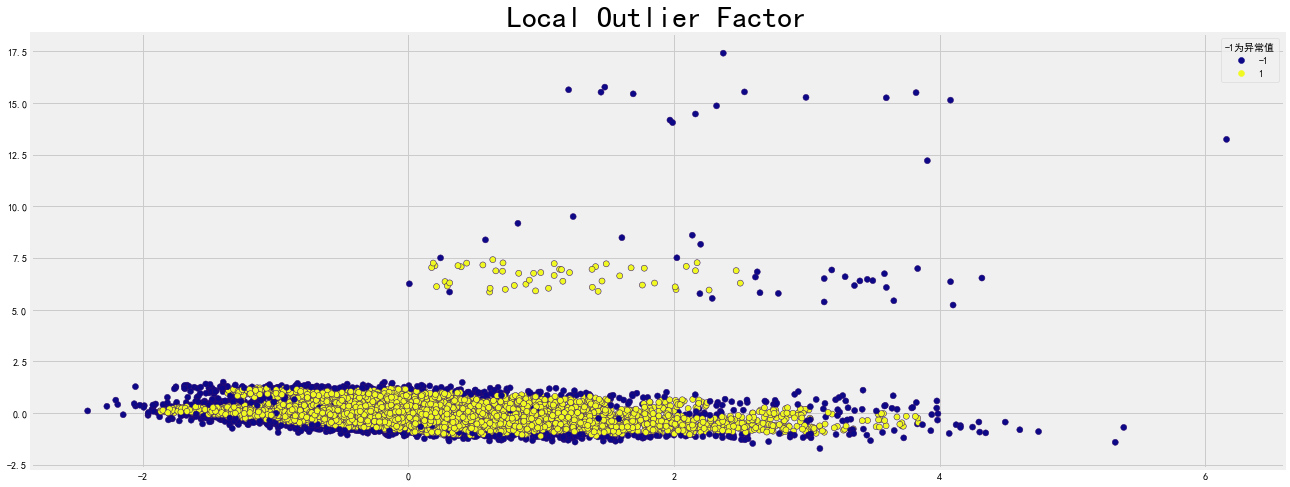

In [ ]:
colors = pred
colormap = list(pd.Series(colors).unique())
plt.figure(figsize = [20,8])
scatter = plt.scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c = colors, cmap = 'plasma',edgecolors='#2f0c6f')
plt.title('Local Outlier Factor', fontsize = 30)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sorted(colormap),
           title="-1为异常值")

In [ ]:
# pip install tushare
import tushare as ts

In [ ]:
df = ts.get_k_data('sh', start='2016-01-01')

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


C:\Users\Admin\anaconda3\lib\site-packages\tushare\stock\trading.py:706: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Admin\anaconda3\lib\site-packages\tushare\stock\trading.py:706: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Admin\anaconda3\lib\site-packages\tushare\stock\trading.py:706: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Admin\anaconda3\lib\site-packages\tushare\stock\trading.py:706: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<AxesSubplot:title={'center':'收盘价时序趋势图'}, xlabel='date'>

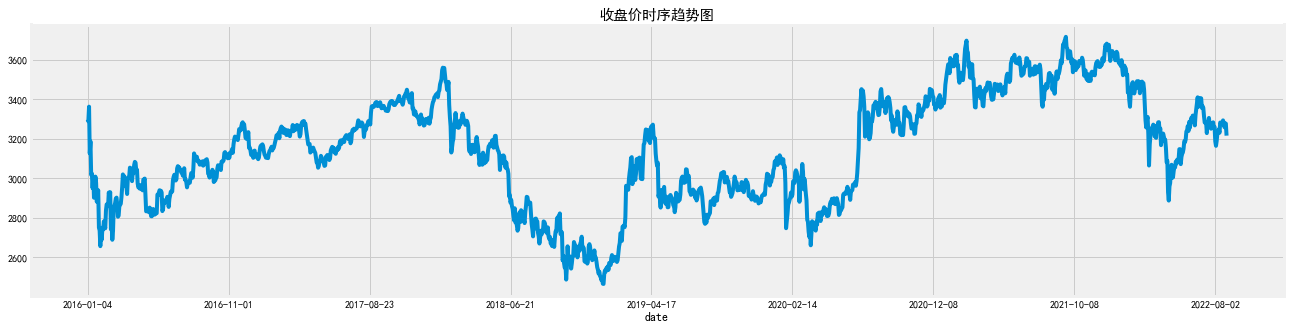

In [ ]:
df.set_index('date').close.plot(figsize = [20,5],title = '收盘价时序趋势图')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=185fc705-b61f-4bb6-be30-c3c88dd0b19b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>